In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)

In [6]:
sample = pl.read_csv('leap-atmospheric-physics-ai-climsim/train.csv', n_rows=1)
TARGETS = ['ptend_t_59',
 'ptend_q0001_0',
 'ptend_q0001_1',
 'ptend_q0001_2',
 'ptend_q0001_3',
 'ptend_q0001_4',
 'ptend_q0001_5',
 'ptend_q0001_6',
 'ptend_q0001_7',
 'ptend_q0001_8',
 'ptend_q0001_9',
 'ptend_q0001_10',
 'ptend_q0001_11',
 'ptend_q0001_12',
 'ptend_q0001_13',
 'ptend_q0001_14',
 'ptend_q0001_59',
 'ptend_q0002_0',
 'ptend_q0002_1',
 'ptend_q0002_2',
 'ptend_q0002_3',
 'ptend_q0002_4',
 'ptend_q0002_5',
 'ptend_q0002_6',
 'ptend_q0002_7',
 'ptend_q0002_8',
 'ptend_q0002_9',
 'ptend_q0002_10',
 'ptend_q0002_11',
 'ptend_q0002_59',
 'ptend_q0003_0',
 'ptend_q0003_1',
 'ptend_q0003_2',
 'ptend_q0003_3',
 'ptend_q0003_4',
 'ptend_q0003_5',
 'ptend_q0003_6',
 'ptend_q0003_7',
 'ptend_q0003_8',
 'ptend_q0003_9',
 'ptend_q0003_10',
 'ptend_q0003_11',
 'ptend_q0003_12',
 'ptend_q0003_13',
 'ptend_q0003_14',
 'ptend_q0003_59',
 'ptend_u_0',
 'ptend_u_1',
 'ptend_u_2',
 'ptend_u_3',
 'ptend_u_4',
 'ptend_u_5',
 'ptend_u_6',
 'ptend_u_7',
 'ptend_u_8',
 'ptend_u_9',
 'ptend_u_10',
 'ptend_u_59',
 'ptend_v_0',
 'ptend_v_1',
 'ptend_v_2',
 'ptend_v_3',
 'ptend_v_4',
 'ptend_v_5',
 'ptend_v_6',
 'ptend_v_7',
 'ptend_v_8',
 'ptend_v_9',
 'ptend_v_10']

all_columns = sample.columns 

# Find indices of TARGETS within all_columns
target_indices = [all_columns.index(target) for target in TARGETS]

print(len(target_indices))

69


In [7]:
BATCH_SIZE = 4096
train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,100)]
valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(100, 102)]
train_options = tf.data.Options()
train_options.deterministic = True

def create_generator(file_paths):
    for file_path in file_paths:
        data = np.load(file_path, allow_pickle=True)
        for sample in data:
            yield sample[:-368], sample[target_indices]

def create_dataset_from_npy(file_paths, batch_size=BATCH_SIZE, shuffle_buffer_size=10000, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_generator(file_paths),
        output_signature=(tf.TensorSpec(shape=(556,), dtype=tf.float64), 
                          tf.TensorSpec(shape=(69,), dtype=tf.float64))
    )
    
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create train dataset
ds_train = create_dataset_from_npy(train_files, BATCH_SIZE, is_training=True)

# Create validation dataset
ds_valid = create_dataset_from_npy(valid_files, BATCH_SIZE, is_training=False)

In [8]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-14 22:42:37.816344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-14 22:46:46.773246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
mean_y = tf.cast(mean_y, tf.float64)
stdd_y = tf.cast(stdd_y, tf.float64)

In [11]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

2024-06-14 22:50:45.234649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 22:54:40.979450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
min_y = tf.cast(min_y, tf.float64)
max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [13]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [14]:
epochs = 12
learning_rate = 0.5e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [15]:
keras.utils.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(556,)),
    tf.keras.layers.Dense(556*4, activation='relu'), 
    tf.keras.layers.Dense(556*2, activation='relu'),
    tf.keras.layers.Dense(556, activation='relu'),
    tf.keras.layers.Dense(69, activation='linear')
])

model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(learning_rate),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2224)           │     1,238,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1112)           │     2,474,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 556)            │       618,828 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 69)             │        38,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,370,229 (16.67 MB)

 Trainable params: 4,370,229 (16.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [17]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/model64weak_wide.keras'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6),
        keras.callbacks.EarlyStopping(patience=5, verbose=1, monitor='val_r2_score', mode='max'),
    ]
)

Epoch 1/12
   2440/Unknown 658s 269ms/step - loss: 22441.3008 - r2_score: 0.0011

2024-06-14 23:05:38.912025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:05:38.912044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/mod/_51]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 664s 271ms/step - loss: 22433.6094 - r2_score: 0.0011 - val_loss: 0.5638 - val_r2_score: 0.0145 - learning_rate: 5.0000e-04
Epoch 2/12


2024-06-14 23:05:44.911976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:05:44.911999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


2439/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 5.8207 - r2_score: 0.0012

2024-06-14 23:15:34.913937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:15:34.913959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_44]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 596s 244ms/step - loss: 5.8318 - r2_score: 0.0012 - val_loss: 3.5553 - val_r2_score: 0.0145 - learning_rate: 5.0000e-04
Epoch 3/12


2024-06-14 23:15:40.662198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:15:40.662222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]


2439/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 148.9877 - r2_score: 0.0011

2024-06-14 23:26:57.405478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:26:57.405503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_44]]



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 683s 279ms/step - loss: 148.9337 - r2_score: 0.0011 - val_loss: 0.0019 - val_r2_score: 0.0145 - learning_rate: 5.0000e-04
Epoch 4/12


2024-06-14 23:27:03.278662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:27:03.278686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2439/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0054 - r2_score: 0.0011

2024-06-14 23:38:12.685532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:38:12.685551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_26]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 675s 276ms/step - loss: 0.0054 - r2_score: 0.0011 - val_loss: 0.0019 - val_r2_score: 0.0145 - learning_rate: 2.5000e-04
Epoch 5/12


2024-06-14 23:38:18.413056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:38:18.413079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[compile_loss/mse/Cast/_12]]


2439/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0054 - r2_score: 0.0012

2024-06-14 23:49:28.237623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:49:28.237643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_36]]



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 676s 277ms/step - loss: 0.0054 - r2_score: 0.0012 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 2.5000e-04
Epoch 6/12


2024-06-14 23:49:33.992398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 23:49:33.992417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[compile_loss/mse/Cast/_12]]


2439/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0053 - r2_score: 0.0011

2024-06-15 00:00:41.419510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 00:00:41.419528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_6/_32]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 673s 276ms/step - loss: 0.0053 - r2_score: 0.0011 - val_loss: 0.0018 - val_r2_score: 0.0145 - learning_rate: 1.2500e-04
Epoch 6: early stopping


2024-06-15 00:00:47.143762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 00:00:47.143783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


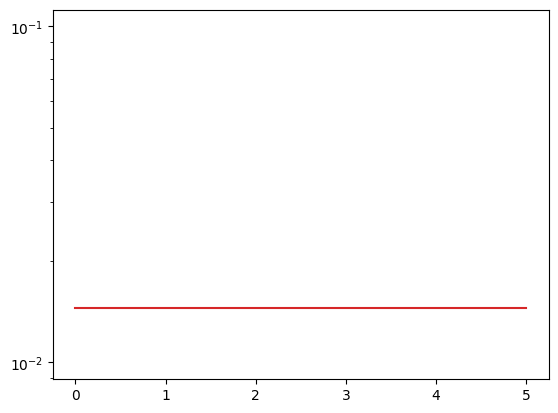

In [18]:
plt.plot(history.history['r2_score'], color='tab:blue')
plt.plot(history.history['val_r2_score'], color='tab:red')
plt.yscale('log');

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-15 00:00:52.815035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step


2024-06-15 00:00:58.699247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
p_valid.numpy()[0]

array([-1.61385873e-13, -1.97755491e-13,  5.09849241e-13,  1.49052822e-13,
       -3.75108886e-14, -1.96287853e-13, -6.57158563e-14, -1.61809049e-14,
       -1.61325887e-13,  1.93767904e-13,  1.10928658e-13, -3.73848573e-14,
        1.30648768e-13, -8.33586952e-14, -3.23502241e-13, -9.03412725e-14,
       -2.08071063e-13, -2.48693864e-13,  8.32638540e-14,  1.00103511e-13,
       -3.27554041e-14,  1.27615665e-13, -7.55440454e-14,  1.78710455e-13,
        1.27730951e-13, -3.79975122e-13, -2.24275648e-14, -8.67761974e-14,
        8.73619411e-14,  4.72991675e-15,  1.54297132e-14, -4.20416740e-14,
        1.14247542e-13,  3.11868805e-13,  1.53468237e-13,  2.97151673e-13,
        1.40057704e-14,  3.19663579e-13,  5.42681671e-14,  1.70164453e-14,
       -1.83740261e-13, -6.85248978e-14,  1.46849886e-13, -8.00983853e-14,
        1.24429369e-13,  3.34946298e-14,  1.63360655e-16,  1.42732486e-13,
       -1.42334951e-13,  5.92495847e-14,  7.74629599e-14,  4.72402876e-14,
        3.81385563e-14, -

In [21]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();